In [130]:
!pip install pandas-plink limix-lmm

In [ ]:
import numpy as np
import pdb 
from pandas_plink import read_plink 
from limix_lmm import LMM
import pylab as plt
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model

In [132]:
import scipy
import scipy.stats as st
if not hasattr(scipy, 'dot'): scipy.dot = np.dot
if not hasattr(scipy, 'einsum'): scipy.einsum = np.einsum
if not hasattr(scipy, 'log'): scipy.log = np.log
if not hasattr(scipy, 'sign'): scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'): scipy.sqrt = np.sqrt

In [133]:
eigenvec = r"../universal_data/preprocessing/chr22_pca10.eigenvec"
df = pd.read_csv(eigenvec, sep=r"\s+", header=None)
ncols = df.shape[1]
pc_cols = list(range(2, ncols))

pcs = df.iloc[:, pc_cols]
pcs_z = (pcs - pcs.mean(axis=0)) / pcs.std(axis=0, ddof=0)


In [134]:
df_z = df.copy()
df_z.iloc[:, pc_cols] = pcs_z
df_z.columns = ["FID", "IID"] + [f"PC{i}" for i in range(1, len(pc_cols) + 1)]
pcs = df_z

In [155]:
# load genetic data
bfile = r'../universal_data/preprocessing/chr22_preprocessed'
bim, fam, G = read_plink(bfile)

X_real = G.compute().T
fam.shape[0]

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 26.91it/s]


2504

In [156]:
# standardization
mu_full = X_real.mean(axis=0)
sd_full = X_real.std(axis=0, ddof=0)
keep_full = sd_full > 1e-12
keep_idx = np.where(keep_full)[0]
standardized_X_real = (X_real[:, keep_full] - mu_full[keep_full]) / sd_full[keep_full]
bim = bim.iloc[keep_idx].copy().reset_index(drop=True)
bim["orig_bim_idx"] = keep_idx

In [137]:
indices = np.arange(standardized_X_real.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
X_train = standardized_X_real[train_idx]
X_test = standardized_X_real[test_idx]

In [196]:
def simulate_pheno(X, idx_caus, var_expl, rng, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (rng.random(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * rng.standard_normal((X.shape[0], 1))

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [201]:
def qq_plot(p_values, idx_caus):
    p_values = np.array(p_values).flatten()
    idx_caus = np.array(idx_caus).flatten()
    sorted_idx = np.argsort(p_values)
    observed = -np.log10(p_values[sorted_idx])
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    plt.scatter(expected, observed, marker='.', label="Non-causal")
    caus_in_sorted = np.argwhere(np.isin(sorted_idx, idx_caus)).flatten()
    plt.scatter(expected[caus_in_sorted], observed[caus_in_sorted], color='red', marker='o', s=20, label='Causal')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.legend()

In [198]:
h2 = 0.6
n_c = 10

In [181]:
rng = np.random.default_rng(42)
idx_caus = rng.choice(standardized_X_real.shape[1], size=n_c, replace=False)
var_expl = np.full(n_c, h2 / n_c)

In [182]:
y, beta_real = simulate_pheno(standardized_X_real, idx_caus, var_expl, rng=rng)

In [183]:
pheno = fam[["fid", "iid"]].copy()
pheno.columns = ["FID", "IID"]
pheno["y"] = y.reshape(-1)
df_merged = pheno.merge(pcs, on=["FID", "IID"], how="inner", validate="one_to_one")
F = np.column_stack([np.ones((df_merged.shape[0], 1)), df_merged[[f"PC{i}" for i in range(1, 11)]].to_numpy()]).astype(np.float64)

In [184]:
y_train = y[train_idx]
y_test = y[test_idx]
F_train = F[train_idx]

In [185]:
lmm = LMM(y_train, F_train)
lmm.process(X_train)
pv = lmm.getPv()
beta = lmm.getBetaSNP()

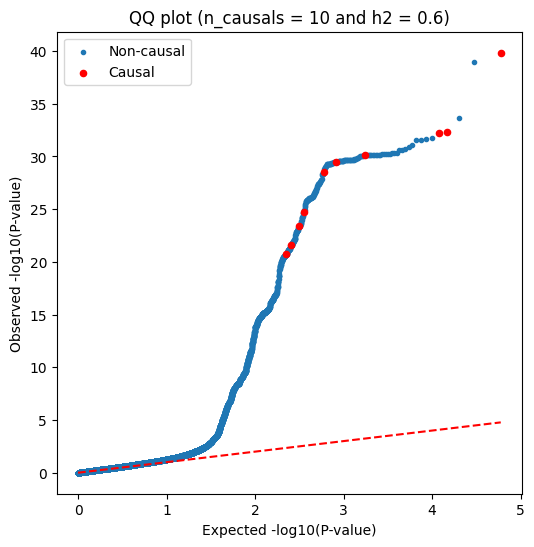

In [202]:
plt.figure(figsize=(6, 6))
qq_plot(pv, idx_caus)
plt.title(f"QQ plot (n_causals = {n_c} and h2 = {h2})")
plt.show()

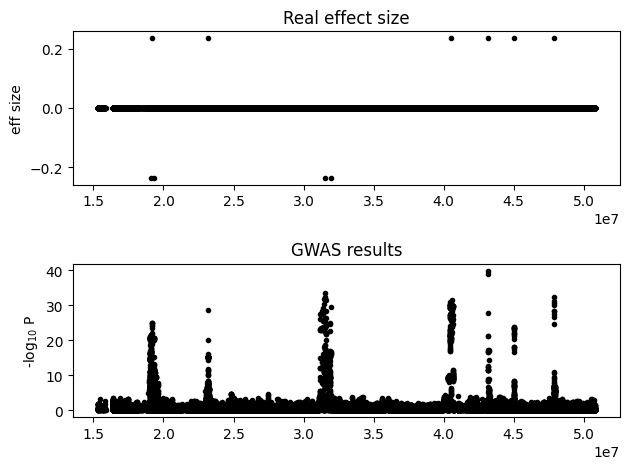

In [194]:
x_pos = bim['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x_pos, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x_pos, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

In [212]:
clumped_file = f"../universal_data/clumping/h2_{h2}/causal_{n_c}/h2_{h2}_causal_{n_c}_clumped.clumped"

clumped = pd.read_csv(clumped_file, sep=r'\s+', engine='python')
selected_snps = clumped['SNP'].values
snp_ids = bim['snp'].values
clumped

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2
0,22,1,rs138948,43181530,1.440000e-40,33,1,1,0,2,29,"rs6519365(1),rs138941(1),rs138942(1),rs138943(..."
1,22,1,rs5753682,31538427,2.320000e-34,172,0,0,2,1,169,"rs73158585(1),rs5997959(1),rs9609263(1),rs7315..."
2,22,1,rs4823720,47878287,5.420000e-33,50,0,0,1,1,48,"rs4823716(1),rs4823717(1),rs62224236(1),rs1210..."
3,22,1,rs200742767,40569771,2.760000e-32,237,0,0,0,1,236,"rs6001894(1),rs9611325(1),rs6001898(1),rs55769..."
4,22,1,rs2015580,31930035,3.290000e-30,146,12,10,14,10,100,"rs76030575(1),rs5994426(1),rs138280(1),rs34733..."
5,22,1,rs2301555,23152717,3.000000e-29,196,6,0,10,28,152,"rs5996446(1),rs9612207(1),rs9612210(1),rs76215..."
6,22,1,rs73158578,31308466,4.930000e-29,35,0,0,1,7,27,"rs147255832(1),rs12485186(1),rs73156792(1),rs5..."
7,22,1,rs5748017,19163333,1.260000e-25,26,3,0,1,0,22,"rs2871016(1),rs1468269(1),rs2871018(1),rs28606..."
8,22,1,rs12159641,45031505,2.080000e-24,69,5,2,5,14,43,"rs5766277(1),rs8142752(1),rs8136316(1),rs81386..."
9,22,1,rs2158335,19101094,2.570000e-22,379,32,1,8,6,332,"rs5992351(1),rs2023635(1),rs2023636(1),rs17810..."


In [213]:
snp_to_col = pd.Series(index=bim["snp"].astype(str), data=range(bim.shape[0]))
cols = snp_to_col.reindex(selected_snps).dropna().astype(int).to_numpy()

In [214]:
X_clump_train = X_train[:, cols]
X_clump_test = X_test[:, cols]

In [215]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

regr = linear_model.LinearRegression()
regr.fit(X_clump_train, y_train)

y_pred = regr.predict(X_clump_test)

In [221]:
from scipy import stats
spearman = stats.spearmanr(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
print("R2", r2_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("spearman r: ", spearman.statistic)


R2 0.5698198514473514
MSE: 0.44389006893513877
spearman r:  0.7459687477634374


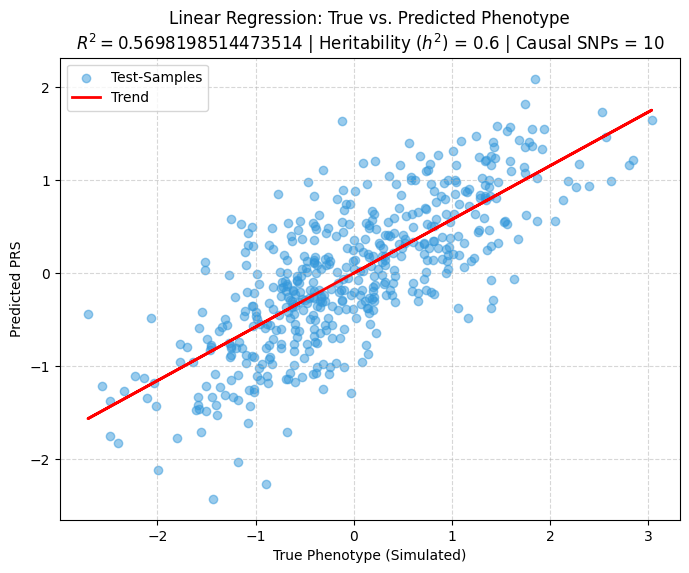

In [226]:
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.5, color='#3498db', label='Test-Samples')

m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='red', linewidth=2, label='Trend')

plt.title(f"Linear Regression: True vs. Predicted Phenotype\n$R^2 = {r2_test}$ | Heritability ($h^2$) = {h2} | Causal SNPs = {n_c}")

plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted PRS")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

R2 Score:   0.4811
Correlation:0.6961


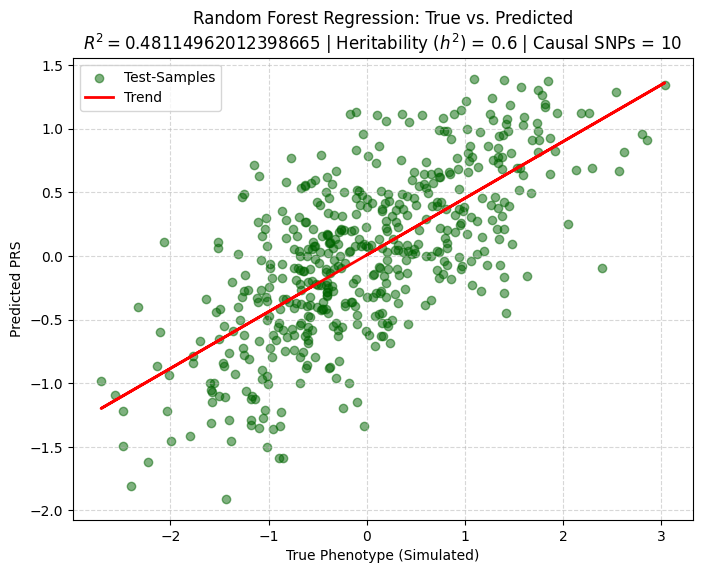

In [233]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=175, 
    max_depth=10,       
    random_state=42, 
    n_jobs=-1           
)

rf_model.fit(X_clump_train, y_train)

y_pred_rf = rf_model.predict(X_clump_test)

r2_rf = r2_score(y_test, y_pred_rf)
corr_rf = st.pearsonr(y_test, y_pred_rf)[0]

print(f"R2 Score:   {r2_rf:.4f}")
print(f"Correlation:{corr_rf:.4f}")

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_rf, alpha=0.5, color='darkgreen', label='Test-Samples')

m, b = np.polyfit(y_test, y_pred_rf, 1)
plt.plot(y_test, m * y_test + b, color='red', linewidth=2, label='Trend')

plt.title(f"Random Forest Regression: True vs. Predicted\n$R^2 = {r2_rf}$ | Heritability ($h^2$) = {h2} | Causal SNPs = {n_c}")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted PRS")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

R2 Score:   0.5697
Correlation:0.7549


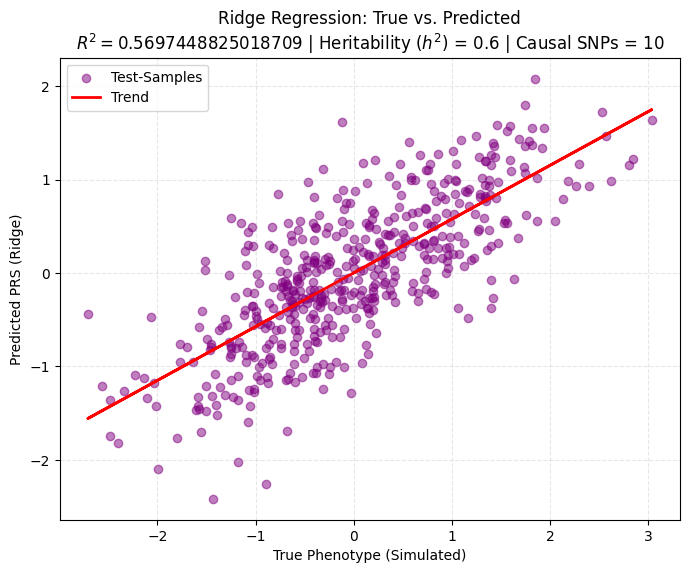

In [234]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np

ridge = RidgeCV(cv=5)
ridge.fit(X_clump_train, y_train)

y_pred_ridge = ridge.predict(X_clump_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
corr_ridge = st.pearsonr(y_test, y_pred_ridge)[0]

print(f"R2 Score:   {r2_ridge:.4f}")
print(f"Correlation:{corr_ridge:.4f}")

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='purple', label='Test-Samples')

m, b = np.polyfit(y_test, y_pred_ridge, 1)
plt.plot(y_test, m * y_test + b, color='red', linewidth=2, label='Trend')

plt.title(f"Ridge Regression: True vs. Predicted\n$R^2 = {r2_ridge}$ | Heritability ($h^2$) = {h2} | Causal SNPs = {n_c}")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted PRS (Ridge)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()